# Schrodinger equation
---

$$
\begin{aligned}
\varepsilon u_t - i\frac{\epsilon^2}{2}\Delta u + i V(x)u = 0, \ t \in \mathbb{R}, x\in \mathbb{R}^d, \\
u(x, t = 0) = u_0(x),
\end{aligned}
$$
where $V$ is a given electrostatic potential, $0 < \varepsilon \ll 1$.

---

Example 2 in Shi Jin's paper:
$$
u(x, 0) = \sqrt{n_0(x)}e^{iS_0(x)/\varepsilon},
$$
(3.9-3.10)
$$
n_0(x) = (e^{-25(x-0.5)^2})^2, \ S_0(x) = 0.2(x^2 - x).
$$

Periodic BC.

---

Consider the real and imag part of $u$, i.e., 
$$
u(x, t) = p(x, t) + iq(x, t),
$$
then
$$
\begin{aligned}
&\varepsilon p_t+\frac{\varepsilon^2}{2}q_{xx} - V(x)q = 0, \\
&\varepsilon q_t-\frac{\varepsilon^2}{2}p_{xx} + V(x)p = 0,
\end{aligned}
$$
with ic
$$
p(x, 0) = e^{-25(x-0.5)^2}\cos(\frac{0.2(x^2-x)}{\varepsilon}), \ q(x, 0) = e^{-25(x-0.5)^2}\sin(\frac{0.2(x^2-x)}{\varepsilon}),
$$
and bc
$$
p(0, t) = p(1, t), q(0, t) = q(1, t), p_x(0, t) = p_x(1, t), q_x(0, t) = q_x(1, t).
$$

In [1]:
NAME = "1_siren"

In [2]:
import jax, jax.nn
from jax import random
import jax.numpy as jnp
from jax.experimental import optimizers

import sys, os
sys.path.append("../../")
	
from Seismic_wave_inversion_PINN.data_utils import *
from Seismic_wave_inversion_PINN.jax_model import *

from collections import namedtuple

In [3]:
key = random.PRNGKey(0)
key, subkey = random.split(key, 2)

layers = [2] + [128]*4 + [2] # (x, t) -> (u, v)
c0 = 6.0
w0 = jnp.array([[1.0], [10.0]]) # (w_x, w_t)
w1 = 1.0
lambda_0 = 1e-8
direct_params = init_siren_params(subkey, layers, c0, w0, w1)

domain = jnp.array([[0., 0.], [1., 0.5]])
epsilon = 1.0
V = 1.0

@jax.jit
def model(params, xt):
	# first, normalize to [-1, 1]
	xt = 2.0*(xt - domain[0, :])/(domain[1, :]-domain[0, :]) - 1.0
	for w, b in params[:-1]:
		xt = jnp.sin(jnp.dot(xt, w) + b)
	return jnp.dot(xt, params[-1][0]) + params[-1][1]

jacobian = jacrev_fn(model)
hessian = hessian_fn(model)

In [4]:
metaloss = mae

jit_conservation = lambda i: jax.partial(jax.jit, static_argnums = i)

@jax.jit
def loss_fn_(params, batch):
	collocation, dirichlet, periodic_bc = batch["collocation"], batch["dirichlet"], batch["periodic_bc"]
	direct_params = params
	
	uv_c = model(direct_params, jnp.hstack([collocation.x, collocation.t]))
	u_c, v_c = uv_c[:, 0:1], uv_c[:, 1:2]
	
	# jacobian[i] = [[du/dx, du/dt],
	#                [dv/dx, dv/dt]]
	# i: the i^th input
	duv_dxt_c = jacobian(direct_params, jnp.hstack([collocation.x, collocation.t]))
	du_dt_c, dv_dt_c = duv_dxt_c[:, 0:1, 1], duv_dxt_c[:, 1:2, 1]
	
	# hessian[i] = [
    #				[[du/dxx, du/dxy],
	#                [du/dxy, du/dyy]],
	#               [[dv/dxx, dv/dxy],
	#                [dv/dxy, dv/dyy]]
	#              ]
	duv_dxxtt_c = hessian(direct_params, jnp.hstack([collocation.x, collocation.t]))
	du_dxx_c, dv_dxx_c = duv_dxxtt_c[:, 0:1, 0, 0], duv_dxxtt_c[:, 1:2, 0, 0] 
	
	uv_l = model(direct_params, jnp.hstack([periodic_bc.l, periodic_bc.t]))
	uv_r = model(direct_params, jnp.hstack([periodic_bc.r, periodic_bc.t]))
	u_l, v_l = uv_l[:, 0:1], uv_l[:, 1:2]
	u_r, v_r = uv_r[:, 0:1], uv_r[:, 1:2]
	
	duv_dxt_l = jacobian(direct_params, jnp.hstack([periodic_bc.l, periodic_bc.t]))
	duv_dxt_r = jacobian(direct_params, jnp.hstack([periodic_bc.r, periodic_bc.t]))
	du_dx_l, dv_dx_l = duv_dxt_l[:, 0:1, 0], duv_dxt_l[:, 1:2, 0]
	du_dx_r, dv_dx_r = duv_dxt_r[:, 0:1, 0], duv_dxt_r[:, 1:2, 0]
		
	uv_d = model(direct_params, jnp.hstack([dirichlet.x, dirichlet.t]))
	u_d, v_d = uv_d[:, 0:1], uv_d[:, 1:2]
	
# 	uv_conservation = model(direct_params, jnp.hstack([conservation.x, conservation.t]))
# 	u_conservation, v_conservation = uv_conservation[:, 0:1].reshape((conservation.nt, conservation.nx)), uv_conservation[:, 1:2].reshape((conservation.nt, conservation.nx))
# 	norm_conservation = jnp.sum(jnp.square(u_conservation)+jnp.square(v_conservation), axis = 1)
# 	uv0_conservation = model(direct_params, jnp.hstack([conservation.x0, conservation.t0]))
# 	u0_con, v0_con = uv0_conservation[:, 0:1], uv0_conservation[:, 1:2]
# 	norm0_con = jnp.sum(jnp.square(u0_con) + jnp.square(v0_con))
# 	loss_conservation = metaloss(norm_conservation - norm0_con, 0)
	
# 	duv_dxt_conservation = jacobian(direct_params, jnp.hstack([conservation.x, conservation.t]))
# 	du_dx_conservation, dv_dx_conservation = duv_dxt_conservation[:, 0:1, 0].reshape((conservation.nt, conservation.nx)), duv_dxt_conservation[:, 1:2, 0].reshape((conservation.nt, conservation.nx))
# 	energy_conservation = (epsilon**2)/2*jnp.sum(du_dx_conservation**2+dv_dx_conservation**2, axis = 1) # + V*norm_conservation
# 	duv0_dxt0_conservation = jacobian(direct_params, jnp.hstack([conservation.x0, conservation.t0]))
# 	du0_dx0_conservation, dv0_dx0_conservation = duv0_dxt0_conservation[:, 0:1, 0], duv0_dxt0_conservation[:, 1:2, 0]
# 	energy0_conservation = (epsilon**2)/2*jnp.sum(du0_dx0_conservation**2+dv0_dx0_conservation**2) # + V*norm0_con <- included in mass con
# 	loss_energy = metaloss(energy_conservation - energy0_conservation, 0)
	
	
	loss_c1 = metaloss(epsilon*du_dt_c + 0.5*epsilon**2*dv_dxx_c - V*v_c, 0)
	loss_c2 = metaloss(epsilon*dv_dt_c - 0.5*epsilon**2*du_dxx_c + V*u_c, 0)
	loss_c = loss_c1 + loss_c2
	
	loss_d1 = metaloss(u_d, dirichlet.u)
	loss_d2 = metaloss(v_d, dirichlet.v)
	loss_d = loss_d1 + loss_d2
	
	loss_pbc_d1 = metaloss(u_l, u_r)
	loss_pbc_d2 = metaloss(v_l, v_r)
	loss_pbc_n1 = metaloss(du_dx_l, du_dx_r)
	loss_pbc_n2 = metaloss(dv_dx_l, dv_dx_r)
	loss_pbc_d = loss_pbc_d1 + loss_pbc_d2
	loss_pbc_n = loss_pbc_n1 + loss_pbc_n2
	
	return loss_c, loss_d, loss_pbc_d, loss_pbc_n


@jax.jit
def loss_fn(params, batch):
	w = batch["weights"]
	loss_c, loss_d, loss_pbc_d, loss_pbc_n = loss_fn_(params, batch)
	return w["c"]*loss_c + w["d"]*loss_d + w["pbc_d"]*loss_pbc_d + w["pbc_n"]*loss_pbc_n + l2_regularization(params, lambda_0)

@jax.jit
def step(i, opt_state, batch):
	params = get_params(opt_state)
	grad = jax.grad(loss_fn, 0)(params, batch)
	return opt_update(i, grad, opt_state)

@jax.jit
def evaluate(params, batch):
	w = batch["weights"]
	loss_c, loss_d, loss_pbc_d, loss_pbc_n = loss_fn_(params, batch)
	return w["c"]*loss_c + w["d"]*loss_d + w["pbc_d"]*loss_pbc_d + w["pbc_n"]*loss_pbc_n, loss_c, loss_d, loss_pbc_d, loss_pbc_n

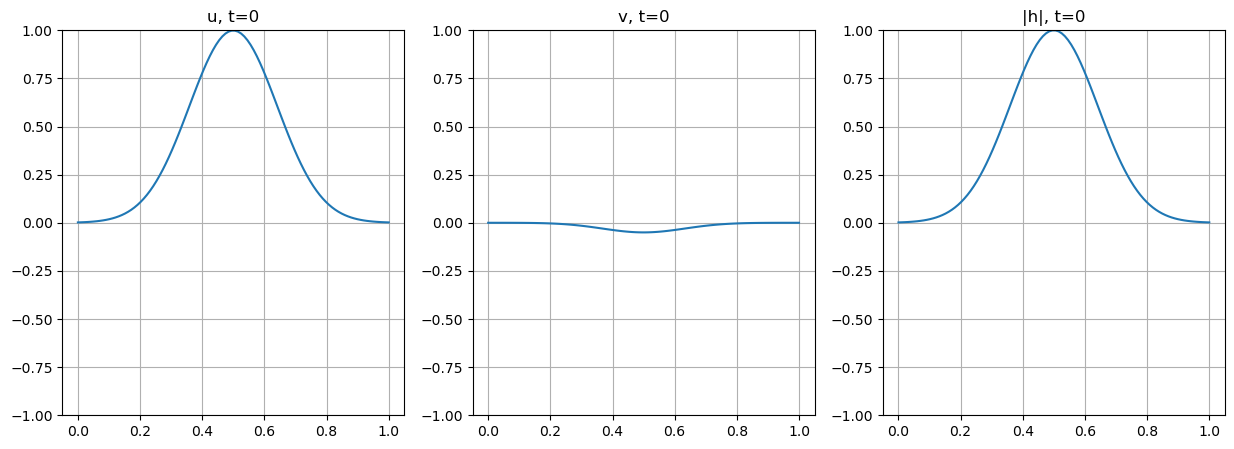

In [5]:
u0_fn = lambda x, t: np.exp(-25*(x-0.5)**2)*np.cos(0.2/epsilon*(x**2-x))
v0_fn = lambda x, t: np.exp(-25*(x-0.5)**2)*np.sin(0.2/epsilon*(x**2-x))
x0 = np.linspace(*domain[:, 0], 100)
t0 = np.zeros_like(x0)
u0 = u0_fn(x0, t0)
v0 = v0_fn(x0, t0)

import matplotlib.pyplot as plt
plt.rcParams.update(plt.rcParamsDefault)

f, ax = plt.subplots(1, 3, figsize = (15, 5))
ax[0].plot(x0, u0)
ax[0].set_title("u, t=0")
ax[0].grid()
ax[0].set_ylim([-1, 1])
ax[1].plot(x0, v0)
ax[1].set_title("v, t=0")
ax[1].grid()
ax[1].set_ylim([-1, 1])
ax[2].plot(x0, np.sqrt(u0**2+v0**2))
ax[2].set_title("|h|, t=0")
ax[2].grid()
ax[2].set_ylim([-1, 1])
plt.show()

key, *subkeys = random.split(key, 3)

n_i = 100
x_i = random.uniform(subkeys[0], (n_i, 1), jnp.float32, *domain[:, 0])
t_i = jnp.zeros_like(x_i)
u_i = u0_fn(x_i, t_i)
v_i = v0_fn(x_i, t_i)

n_b = 100
t_b = random.uniform(subkeys[1], (n_b, 1), jnp.float32, *domain[:, 1])
x_lb = jnp.ones_like(t_b)*domain[0, 0]
x_rb = jnp.ones_like(t_b)*domain[1, 0]

n_cx = 100
n_ct = 20
x_c = jnp.linspace(*domain[:, 0], n_cx)
t_c = jnp.linspace(*domain[:, 1], n_ct)
xt_c = tensor_grid([x_c, t_c])

dataset_Dirichlet = namedtuple("dataset_Dirichlet", ["x", "t", "u", "v"])
dataset_Collocation = namedtuple("dataset_Collocation", ["x", "t"])
dataset_BC = namedtuple("dataset_BC", ["l", "r", "t"])

dirichlet = dataset_Dirichlet(x_i, t_i, u_i, v_i)
periodic_bc = dataset_BC(x_lb, x_rb, t_b)
collocation = dataset_Collocation(jnp.vstack([dirichlet.x, periodic_bc.l, periodic_bc.r, xt_c[:, 0:1]]),
								  jnp.vstack([dirichlet.t, periodic_bc.t, periodic_bc.t, xt_c[:, 1:2]]))

In [6]:
lr = 1e-4
start_iteration = 0
iterations = 100000
print_every = 500
save_every = 10000
batch_size = {"dirichlet": 100, "bc": 100, "collocation": 640}
weights = {"c": 1.0, "d": 1e4, "pbc_d": 1e4, "pbc_n": 1e4}

key, *subkeys = random.split(key, 4)
Dirichlet = Batch_Generator(subkeys[0], dirichlet, batch_size["dirichlet"])
Collocation = Batch_Generator(subkeys[1], collocation, batch_size["collocation"])
BC = Batch_Generator(subkeys[2], periodic_bc, batch_size["bc"])
params = direct_params

opt_init, opt_update, get_params = optimizers.adam(lr)
opt_state = opt_init(params)
hist = {"iter": [], "loss": []}

for iteration in range(start_iteration, start_iteration+iterations+1):
	batch = {
		"dirichlet": dataset_Dirichlet(*next(Dirichlet)),
		"collocation": dataset_Collocation(*next(Collocation)),
		"periodic_bc": dataset_BC(*next(BC)),
		"weights": weights
	}
	opt_state = step(iteration, opt_state, batch)
	if (iteration-start_iteration) % print_every == 0:
		names = ["Loss", "c", "d", "pbc_d", "pbc_n"]
		params_ = get_params(opt_state)
		losses = evaluate(params_, batch)
		print("{}, Iteration: {}, Train".format(get_time(), iteration) + \
			  ','.join([" {}: {:.4e}".format(name, loss) for name, loss in zip(names, losses)]))
		hist["iter"].append(iteration)
		hist["loss"].append(losses)
	if (iteration-start_iteration) % save_every == 0:
		params_ = np.asarray(get_params(opt_state), dtype = object)
		save_path = "models/{}/iteration_{}/params.npy".format(NAME, iteration)
		if not os.path.exists(os.path.dirname(save_path)):
			os.makedirs(os.path.dirname(save_path))
		np.save(save_path, params_)

2020/08/06, 21:48:39, Iteration: 0, Train Loss: 1.0841e+05, c: 8.9076e+01, d: 1.3643e+00, pbc_d: 2.1805e+00, pbc_n: 7.2868e+00
2020/08/06, 21:48:49, Iteration: 500, Train Loss: 9.0140e+02, c: 6.6013e+01, d: 1.0432e-02, pbc_d: 1.6355e-02, pbc_n: 5.6753e-02
2020/08/06, 21:48:56, Iteration: 1000, Train Loss: 6.0909e+02, c: 6.7542e+01, d: 1.0264e-02, pbc_d: 1.0401e-02, pbc_n: 3.3490e-02
2020/08/06, 21:49:01, Iteration: 1500, Train Loss: 7.0223e+02, c: 6.2030e+01, d: 5.9693e-03, pbc_d: 1.0888e-02, pbc_n: 4.7163e-02
2020/08/06, 21:49:07, Iteration: 2000, Train Loss: 6.8864e+02, c: 6.2920e+01, d: 8.6805e-03, pbc_d: 8.3931e-03, pbc_n: 4.5498e-02
2020/08/06, 21:49:13, Iteration: 2500, Train Loss: 8.0574e+02, c: 5.8885e+01, d: 1.3727e-02, pbc_d: 9.2735e-03, pbc_n: 5.1684e-02
2020/08/06, 21:49:20, Iteration: 3000, Train Loss: 5.6057e+02, c: 5.8728e+01, d: 5.6253e-03, pbc_d: 7.5837e-03, pbc_n: 3.6976e-02
2020/08/06, 21:49:26, Iteration: 3500, Train Loss: 5.1940e+02, c: 5.5130e+01, d: 7.2633e-03, p

2020/08/06, 21:55:02, Iteration: 31500, Train Loss: 5.2849e+02, c: 1.4637e+01, d: 1.0520e-02, pbc_d: 6.4967e-03, pbc_n: 3.4369e-02
2020/08/06, 21:55:08, Iteration: 32000, Train Loss: 3.8184e+02, c: 1.5277e+01, d: 7.1542e-03, pbc_d: 6.5715e-03, pbc_n: 2.2931e-02
2020/08/06, 21:55:14, Iteration: 32500, Train Loss: 4.7243e+02, c: 1.3536e+01, d: 5.8664e-03, pbc_d: 8.6377e-03, pbc_n: 3.1385e-02
2020/08/06, 21:55:20, Iteration: 33000, Train Loss: 4.2456e+02, c: 1.3939e+01, d: 5.1582e-03, pbc_d: 5.5806e-03, pbc_n: 3.0323e-02
2020/08/06, 21:55:26, Iteration: 33500, Train Loss: 3.7556e+02, c: 1.3636e+01, d: 6.7177e-03, pbc_d: 4.6395e-03, pbc_n: 2.4835e-02
2020/08/06, 21:55:33, Iteration: 34000, Train Loss: 3.7721e+02, c: 1.3541e+01, d: 5.7042e-03, pbc_d: 7.3306e-03, pbc_n: 2.3332e-02
2020/08/06, 21:55:38, Iteration: 34500, Train Loss: 4.5269e+02, c: 1.4220e+01, d: 5.8111e-03, pbc_d: 8.0967e-03, pbc_n: 2.9939e-02
2020/08/06, 21:55:44, Iteration: 35000, Train Loss: 4.9797e+02, c: 1.3250e+01, d: 7

2020/08/06, 22:01:22, Iteration: 63000, Train Loss: 2.8345e+02, c: 6.7233e+00, d: 5.3150e-03, pbc_d: 6.4977e-03, pbc_n: 1.5860e-02
2020/08/06, 22:01:29, Iteration: 63500, Train Loss: 3.8638e+02, c: 7.1905e+00, d: 7.5644e-03, pbc_d: 6.7625e-03, pbc_n: 2.3592e-02
2020/08/06, 22:01:35, Iteration: 64000, Train Loss: 3.0477e+02, c: 7.0453e+00, d: 5.1991e-03, pbc_d: 4.3780e-03, pbc_n: 2.0195e-02
2020/08/06, 22:01:41, Iteration: 64500, Train Loss: 3.5311e+02, c: 6.6614e+00, d: 5.9827e-03, pbc_d: 6.4400e-03, pbc_n: 2.2223e-02
2020/08/06, 22:01:47, Iteration: 65000, Train Loss: 2.3383e+02, c: 6.7467e+00, d: 2.6870e-03, pbc_d: 5.4731e-03, pbc_n: 1.4548e-02
2020/08/06, 22:01:53, Iteration: 65500, Train Loss: 2.8588e+02, c: 6.3552e+00, d: 3.5250e-03, pbc_d: 5.7766e-03, pbc_n: 1.8651e-02
2020/08/06, 22:01:59, Iteration: 66000, Train Loss: 2.7270e+02, c: 6.9101e+00, d: 2.6063e-03, pbc_d: 5.8836e-03, pbc_n: 1.8090e-02
2020/08/06, 22:02:05, Iteration: 66500, Train Loss: 2.7337e+02, c: 6.5650e+00, d: 4

2020/08/06, 22:07:43, Iteration: 94500, Train Loss: 2.0840e+02, c: 4.2531e+00, d: 3.3269e-03, pbc_d: 4.2906e-03, pbc_n: 1.2798e-02
2020/08/06, 22:07:48, Iteration: 95000, Train Loss: 2.1755e+02, c: 4.4394e+00, d: 5.9436e-03, pbc_d: 3.2934e-03, pbc_n: 1.2074e-02
2020/08/06, 22:07:54, Iteration: 95500, Train Loss: 2.2658e+02, c: 4.5023e+00, d: 2.6724e-03, pbc_d: 5.1288e-03, pbc_n: 1.4407e-02
2020/08/06, 22:08:01, Iteration: 96000, Train Loss: 2.0926e+02, c: 4.3108e+00, d: 4.9365e-03, pbc_d: 5.5635e-03, pbc_n: 9.9944e-03
2020/08/06, 22:08:07, Iteration: 96500, Train Loss: 2.2013e+02, c: 4.2036e+00, d: 4.1396e-03, pbc_d: 3.9981e-03, pbc_n: 1.3455e-02
2020/08/06, 22:08:13, Iteration: 97000, Train Loss: 2.6898e+02, c: 4.1207e+00, d: 6.1930e-03, pbc_d: 6.7276e-03, pbc_n: 1.3565e-02
2020/08/06, 22:08:18, Iteration: 97500, Train Loss: 2.0302e+02, c: 4.2411e+00, d: 3.0703e-03, pbc_d: 4.6498e-03, pbc_n: 1.2158e-02
2020/08/06, 22:08:24, Iteration: 98000, Train Loss: 2.0536e+02, c: 4.1206e+00, d: 3

In [8]:
lr = 1e-4
start_iteration += iterations
iterations = 100000
print_every = 500
save_every = 10000
batch_size = {"dirichlet": 100, "bc": 100, "collocation": 1000}
weights = {"c": 1.0, "d": 1e4, "pbc_d": 1e3, "pbc_n": 1e2}

for iteration in range(start_iteration, start_iteration+iterations+1):
	batch = {
		"dirichlet": dataset_Dirichlet(*next(Dirichlet)),
		"collocation": dataset_Collocation(*next(Collocation)),
		"periodic_bc": dataset_BC(*next(BC)),
		"weights": weights
	}
	opt_state = step(iteration, opt_state, batch)
	if (iteration-start_iteration) % print_every == 0:
		names = ["Loss", "c", "d", "pbc_d", "pbc_n"]
		params_ = get_params(opt_state)
		losses = evaluate(params_, batch)
		print("{}, Iteration: {}, Train".format(get_time(), iteration) + \
			  ','.join([" {}: {:.4e}".format(name, loss) for name, loss in zip(names, losses)]))
		hist["iter"].append(iteration)
		hist["loss"].append(losses)
	if (iteration-start_iteration) % save_every == 0:
		params_ = np.asarray(get_params(opt_state), dtype = object)
		save_path = "models/{}/iteration_{}/params.npy".format(NAME, iteration)
		if not os.path.exists(os.path.dirname(save_path)):
			os.makedirs(os.path.dirname(save_path))
		np.save(save_path, params_)

2020/08/06, 22:22:20, Iteration: 100000, Train Loss: 6.3527e+01, c: 4.0419e+00, d: 5.0603e-03, pbc_d: 7.0509e-03, pbc_n: 1.8312e-02
2020/08/06, 22:22:26, Iteration: 100500, Train Loss: 4.4745e+01, c: 4.0647e+00, d: 3.8754e-03, pbc_d: 1.6953e-03, pbc_n: 2.3087e-03
2020/08/06, 22:22:32, Iteration: 101000, Train Loss: 5.5700e+01, c: 3.9525e+00, d: 4.8197e-03, pbc_d: 3.2971e-03, pbc_n: 2.5291e-03
2020/08/06, 22:22:38, Iteration: 101500, Train Loss: 6.1721e+01, c: 3.7477e+00, d: 5.4532e-03, pbc_d: 3.1097e-03, pbc_n: 3.3195e-03
2020/08/06, 22:22:44, Iteration: 102000, Train Loss: 6.3163e+01, c: 3.7078e+00, d: 5.5542e-03, pbc_d: 3.6371e-03, pbc_n: 2.7621e-03
2020/08/06, 22:22:50, Iteration: 102500, Train Loss: 1.0496e+02, c: 3.9114e+00, d: 9.7295e-03, pbc_d: 3.2442e-03, pbc_n: 5.0544e-03
2020/08/06, 22:22:56, Iteration: 103000, Train Loss: 4.8654e+01, c: 3.7144e+00, d: 4.1649e-03, pbc_d: 2.9166e-03, pbc_n: 3.7414e-03
2020/08/06, 22:23:02, Iteration: 103500, Train Loss: 1.2121e+02, c: 3.4861e+

2020/08/06, 22:28:40, Iteration: 131500, Train Loss: 4.9605e+01, c: 1.2916e+00, d: 4.4010e-03, pbc_d: 3.8034e-03, pbc_n: 4.9993e-03
2020/08/06, 22:28:46, Iteration: 132000, Train Loss: 7.5615e+01, c: 1.5584e+00, d: 6.7789e-03, pbc_d: 5.7303e-03, pbc_n: 5.3716e-03
2020/08/06, 22:28:52, Iteration: 132500, Train Loss: 3.8964e+01, c: 1.5255e+00, d: 3.2196e-03, pbc_d: 4.8415e-03, pbc_n: 4.0112e-03
2020/08/06, 22:28:58, Iteration: 133000, Train Loss: 5.3962e+01, c: 1.5742e+00, d: 4.7996e-03, pbc_d: 3.8170e-03, pbc_n: 5.7438e-03
2020/08/06, 22:29:04, Iteration: 133500, Train Loss: 5.7682e+01, c: 1.5120e+00, d: 5.1384e-03, pbc_d: 4.3008e-03, pbc_n: 4.8527e-03
2020/08/06, 22:29:10, Iteration: 134000, Train Loss: 7.7190e+01, c: 1.3347e+00, d: 7.1464e-03, pbc_d: 3.9979e-03, pbc_n: 3.9317e-03
2020/08/06, 22:29:16, Iteration: 134500, Train Loss: 6.5989e+01, c: 1.5112e+00, d: 5.9002e-03, pbc_d: 4.9578e-03, pbc_n: 5.1795e-03
2020/08/06, 22:29:22, Iteration: 135000, Train Loss: 6.1832e+01, c: 1.3057e+

2020/08/06, 22:35:01, Iteration: 163000, Train Loss: 2.9272e+01, c: 1.0322e+00, d: 2.4964e-03, pbc_d: 2.8146e-03, pbc_n: 4.6166e-03
2020/08/06, 22:35:07, Iteration: 163500, Train Loss: 4.4783e+01, c: 1.0541e+00, d: 3.9300e-03, pbc_d: 3.8595e-03, pbc_n: 5.6935e-03
2020/08/06, 22:35:13, Iteration: 164000, Train Loss: 4.8713e+01, c: 1.0652e+00, d: 4.1327e-03, pbc_d: 5.7865e-03, pbc_n: 5.3468e-03
2020/08/06, 22:35:19, Iteration: 164500, Train Loss: 4.4545e+01, c: 1.1263e+00, d: 3.9301e-03, pbc_d: 3.5873e-03, pbc_n: 5.3041e-03
2020/08/06, 22:35:25, Iteration: 165000, Train Loss: 3.9963e+01, c: 1.0095e+00, d: 3.3532e-03, pbc_d: 4.9014e-03, pbc_n: 5.1969e-03
2020/08/06, 22:35:31, Iteration: 165500, Train Loss: 7.6366e+01, c: 1.0350e+00, d: 7.0069e-03, pbc_d: 4.6831e-03, pbc_n: 5.7835e-03
2020/08/06, 22:35:37, Iteration: 166000, Train Loss: 8.3717e+01, c: 1.0569e+00, d: 7.8969e-03, pbc_d: 3.1964e-03, pbc_n: 4.9467e-03
2020/08/06, 22:35:43, Iteration: 166500, Train Loss: 4.4903e+01, c: 1.0632e+

2020/08/06, 22:41:19, Iteration: 194500, Train Loss: 4.4822e+01, c: 7.4010e-01, d: 3.9538e-03, pbc_d: 3.9542e-03, pbc_n: 5.8888e-03
2020/08/06, 22:41:25, Iteration: 195000, Train Loss: 2.9520e+01, c: 7.8957e-01, d: 2.5257e-03, pbc_d: 3.0516e-03, pbc_n: 4.2240e-03
2020/08/06, 22:41:31, Iteration: 195500, Train Loss: 5.1180e+01, c: 7.7485e-01, d: 4.2482e-03, pbc_d: 7.1848e-03, pbc_n: 7.3893e-03
2020/08/06, 22:41:37, Iteration: 196000, Train Loss: 4.1709e+01, c: 8.8475e-01, d: 3.4682e-03, pbc_d: 5.6269e-03, pbc_n: 5.1608e-03
2020/08/06, 22:41:43, Iteration: 196500, Train Loss: 5.5511e+01, c: 7.8814e-01, d: 4.8531e-03, pbc_d: 5.7897e-03, pbc_n: 4.0205e-03
2020/08/06, 22:41:49, Iteration: 197000, Train Loss: 3.3845e+01, c: 8.1377e-01, d: 2.7237e-03, pbc_d: 5.0561e-03, pbc_n: 7.3755e-03
2020/08/06, 22:41:55, Iteration: 197500, Train Loss: 4.5278e+01, c: 7.9116e-01, d: 3.9585e-03, pbc_d: 4.5118e-03, pbc_n: 3.8976e-03
2020/08/06, 22:42:01, Iteration: 198000, Train Loss: 3.7296e+01, c: 7.9435e-

<IPython.core.display.Javascript object>


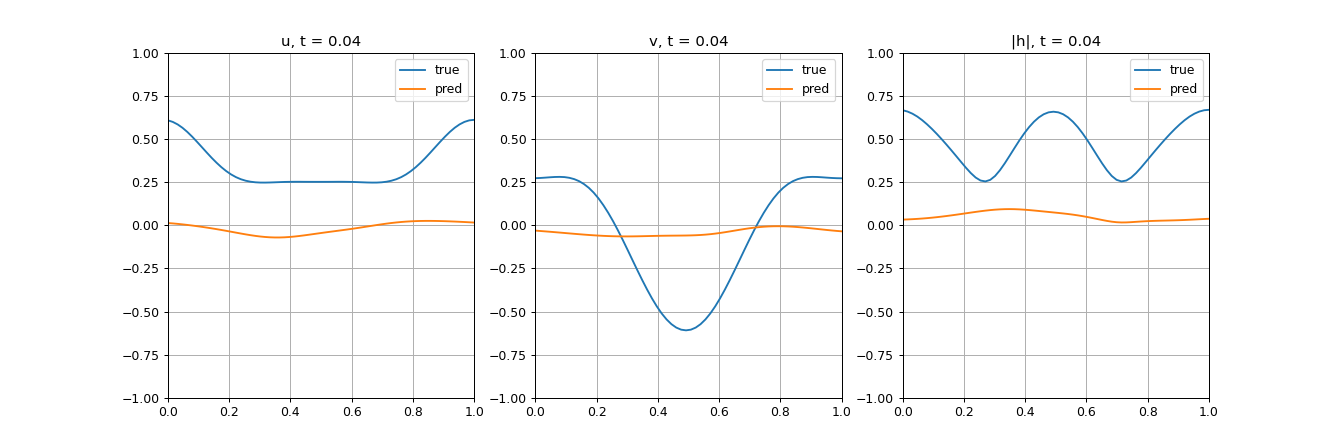

In [9]:
from scipy.io import loadmat

uv_true = loadmat("epsilon_1.0.mat")["u"].T

from matplotlib import animation
%matplotlib notebook

fig, ax = plt.subplots(1, 3, figsize = (15, 5))
lines = []
for i in range(3):
    line1, = ax[i].plot([], [], lw = 1.5, label = "true")
    line2, = ax[i].plot([], [], lw = 1.5, label = "pred")
    lines.extend([line1, line2])
    ax[i].set_xlim([0, 1])
    ax[i].set_ylim([-1, 1])
    ax[i].legend()
    ax[i].grid()
    
def init():
	for line in lines:
		line.set_data([], [])
	return lines

params_ = get_params(opt_state)

x_test = jnp.linspace(*domain[:, 0], 64)
t_test = jnp.linspace(*domain[:, 1], 101)
xt_tests = [tensor_grid([x_test, ti]) for ti in t_test]
uv_preds = [model(params_, xt_test) for xt_test in xt_tests]
u_preds, v_preds = [uv_pred[:, 0:1] for uv_pred in uv_preds], [uv_pred[:, 1:2] for uv_pred in uv_preds]

def animate(i):
	u_pred, v_pred = u_preds[i], v_preds[i]
	u_true, v_true = np.real(uv_true[i, :]), np.imag(uv_true[i, :])
	
	lines[0].set_data(x_test, u_true)
	lines[1].set_data(x_test, u_pred)
	ax[0].set_title("u, t = {:.2f}".format(t_test[i]))
    
	lines[2].set_data(x_test, v_true)
	lines[3].set_data(x_test, v_pred)
	ax[1].set_title("v, t = {:.2f}".format(t_test[i]))

	lines[4].set_data(x_test, np.sqrt(u_true**2+v_true**2))
	lines[5].set_data(x_test, np.sqrt(u_pred**2+v_pred**2))
	ax[2].set_title("|h|, t = {:.2f}".format(t_test[i]))

	return lines

anim = animation.FuncAnimation(fig, animate, frames = len(t_test), interval = 1000, blit = True)
plt.show()

In [ ]:
uv_true.shape